# Import, Helper

In [131]:
import numpy as np
import random
import pickle
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

REWARD = 10000
PENALTY = -10000

In [59]:
def animate_probing(board_history, grid_size, target_positions, episode, total_reward, tr_episodes):
    fig, ax = plt.subplots()
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)

    scatters = [ax.scatter([], [], s=100) for _ in range(3)]
    for target_position in target_positions:
        target_scatter = ax.scatter(target_position[0], target_position[1], c='red', marker='x', s=100)

    def update(frame):
        state = board_history[frame]
        artists = []
        for scatter, pos in zip(scatters, state):
            scatter.set_offsets(pos)
            artists.append(scatter)
        return artists

    ani = FuncAnimation(fig, update, frames=len(board_history), repeat=False, blit=True)
    # plt.title(f'Probing Animation at Episode {episode}')
    # plt.show()
    ani.save(f'anims/probing_animation_{tr_episodes}_score_{total_reward}.gif', writer='pillow', fps=2)
    fig.clear()
    return ani

def draw_trajectory(board_history, grid_size, target_positions, episode, total_reward):
    fig, ax = plt.subplots()
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    
    for target_position in target_positions:
        target_scatter = ax.scatter(target_position[0], target_position[1], c='red', marker='x', s=100, label='Target')

    num_steps = len(board_history)
    alpha_increase = np.linspace(0.1, 1, num_steps)
    colors = cm.rainbow(np.linspace(0, 1, len(board_history[0])))

    for idx in range(len(board_history[0])):
        positions = [state[idx] for state in board_history]
        positions = np.array(positions)
        for i in range(len(positions)-1):
            ax.plot(positions[i:i+2, 0], positions[i:i+2, 1], marker='o', color=colors[idx], linestyle='-', linewidth=2, alpha=alpha_increase[i])
        ax.plot(positions[:, 0], positions[:, 1], marker='o', color=colors[idx], linestyle='None', alpha=alpha_increase[-1], label=f'Agent {idx+1}')

    plt.title(f'Trajectory at Episode {episode} with Total Reward: {total_reward}')
    plt.legend()
    plt.show()

# Agent

In [99]:
# Q-learning agent, state informtaion is the position of agents, shared by all agents.
class QLearning:
    def __init__(self, num_agents =3 , action_size =4, learning_rate=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.num_agents = num_agents
        self.action_size = action_size
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = {}

    def _get_q_values(self, state):
        # Initialize Q-values for the state if not present: matrix of shape (num_agents, action_size)
        return self.q_table.setdefault(state, np.zeros(self.action_size))

    def choose_action(self, state):
        actions = []
        if np.random.rand() <= self.epsilon:
            actions = tuple(np.random.randint(0, 4, 3))
        else:
            q_values = self._get_q_values(state)
            actions = np.unravel_index(np.argmax(q_values, axis=None), q_values.shape)
        return actions

    def update_q_value(self, state, actions, reward, next_state):
        current_q_values = self._get_q_values(state)
        next_q_values = self._get_q_values(next_state)

        # Update Q-values
        best_next_action = np.unravel_index(np.argmax(next_q_values), next_q_values.shape)
        td_target = reward + self.gamma * next_q_values[best_next_action]
        current_q_values[actions] += self.lr * (td_target - current_q_values[actions])

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, filename):
        with open(os.path.join('./policies', filename), 'wb') as f:
            pickle.dump(self.q_table, f)

    def load(self, filename):
        with open(filename, 'rb') as f:
            self.q_table = pickle.load(f)


## Independent Agent

In [105]:
# Independent Q-Learning, state information is not shared among agents 
class IndQLearning:
    def __init__(self, action_size = 4, learning_rate=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.action_size = action_size
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = {}

    def _get_q_values(self, state):
        return self.q_table.setdefault(state, np.zeros(self.action_size))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randint(0, self.action_size - 1)
        q_values = self._get_q_values(state)
        return np.argmax(q_values)

    def update_q_value(self, state, action, reward, next_state):
        q_values = self._get_q_values(state)
        next_q_values = self._get_q_values(next_state)
        best_next_action = np.argmax(next_q_values)
        td_target = reward + self.gamma * next_q_values[best_next_action]
        q_values[action] += self.lr * (td_target - q_values[action])
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, filename):
        with open(os.path.join('./policies', filename), 'wb') as f:
            pickle.dump(self.q_table, f)
    
    def load(self, filename):
        with open(filename, 'rb') as f:
            self.q_table = pickle.load(f)

# Stage Aware Agent

In [ ]:

class StageAwareQLearning(QLearning):
    def _get_q_values(self, state):
        # State includes both position and current goal number as state information
        return self.q_table.setdefault((state['position'], state['stage']), np.zeros(self.action_size))

    # def choose_action(self, state):
    #     # Adjust state to include stage information
    #     stage_state = (state['position'], state['stage'])
    #     return super().choose_action(stage_state)

    def update_q_value(self, state, action, reward, next_state):
        # Include stage information in state during update
        stage_state = (state['position'], state['stage'])
        stage_next_state = (next_state['position'], next_state['stage'])
        super().update_q_value(stage_state, action, reward, stage_next_state)

class HistoricalVisitedGridQLearning(QLearning):
    def __init__(self, action_size, grid_size, learning_rate=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        super().__init__(action_size, learning_rate, discount_factor, epsilon, epsilon_decay, epsilon_min)
        self.grid_size = grid_size
        self.visited_map = np.zeros((grid_size, grid_size))

    def reset(self):
        # Reset the visited map for the start of each episode
        self.visited_map = np.zeros((self.grid_size, self.grid_size))

    def _get_q_values(self, state):
        # Use the visited map as the state
        visited_flat = tuple(self.visited_map.flatten())
        return self.q_table.setdefault(visited_flat, np.zeros(self.action_size))

    def choose_action(self, position):
        # Update the visited map
        self.visited_map[position[0], position[1]] = 1
        # Flatten the visited map to form the state
        visited_flat = tuple(self.visited_map.flatten())
        return super().choose_action(visited_flat)

    def update_q_value(self, state, action, reward, next_state):
        # State and next state are the flattened visited maps
        state_flat = tuple(self.visited_map.flatten())
        self.visited_map[next_state[0], next_state[1]] = 1
        next_state_flat = tuple(self.visited_map.flatten())
        super().update_q_value(state_flat, action, reward, next_state_flat)

# Env

In [30]:
class Environment:
    def __init__(self, grid_size, target_position):
        self.grid_size = grid_size
        self.target_position = target_position
        self.target_positions = [target_position]
        self.reset()

    def reset(self, rnd = False):
        self.objects = [{'pos': np.random.randint(0, self.grid_size, 2), 'vel': np.zeros(2, dtype=int)} for _ in range(3)]
        if rnd:
            self.target_position = np.random.randint(0, self.grid_size, 2)
            self.target_positions = [self.target_position]
        return self._get_state()

    def _get_state(self):
        return tuple(tuple(obj['pos']) for obj in self.objects)
    def get_board(self):
        agent_positions = [obj['pos'] for obj in self.objects]
        return agent_positions
    def _is_collision(self, positions):
        return len(set(map(tuple, positions))) < len(positions)
    def _is_found_goal(self, positions, target_position):
        return tuple(target_position) in self._get_state()
    
    def step(self, actions):
        reward = 0
        done = False
        for idx, (obj, action) in enumerate(zip(self.objects, actions)):
            move = np.array([0, 0])
            if action == 0:  # Up
                move[1] = 1
            elif action == 1:  # Down
                move[1] = -1
            elif action == 2:  # Left
                move[0] = -1
            elif action == 3:  # Right
                move[0] = 1
            obj['vel'] = move
            reward -= np.sum(np.abs(obj['vel']))
            obj['pos'] = np.clip(obj['pos'] + obj['vel'], 0, self.grid_size - 1)

        positions = [obj['pos'] for obj in self.objects]

        if self._is_collision(positions):
            reward += PENALTY
            done = True

        if self._is_found_goal(positions, self.target_position):
            reward += REWARD
            done = True

        next_state = self._get_state()
        return next_state, reward, done
    
class SequentialGoalsEnvironment:
    def __init__(self, grid_size, target_positions, num_goals=3):
        self.grid_size = grid_size
        self.target_positions = target_positions
        self.num_goals = num_goals
        self.current_goal = 0
        self.reset()

    def get_board(self):
        agent_positions = [obj['pos'] for obj in self.objects]
        return agent_positions

    def reset(self, rnd=False):
        self.objects = [{'pos': np.random.randint(0, self.grid_size, 2), 'vel': np.zeros(2, dtype=int)} for _ in range(3)]
        self.current_goal = 0
        self.target_position = self.target_positions[self.current_goal]
        if rnd:
            self.target_position = np.random.randint(0, self.grid_size, 2)
        return self._get_state()
    
    def next_goal(self):
        self.current_goal += 1
        if self.current_goal < self.num_goals:
            self.target_position = self.target_positions[self.current_goal]
            return False
        return True

    def _get_state(self):
        return tuple(tuple(obj['pos']) for obj in self.objects) + (self.current_goal,)

    def _is_collision(self, positions):
        return len(set(map(tuple, positions))) < len(positions)

    def _is_found_goal(self, positions, target_position):
        return tuple(target_position) in tuple(tuple(obj['pos']) for obj in self.objects)

    def step(self, actions):
        reward = 0
        done = False
        for idx, (obj, action) in enumerate(zip(self.objects, actions)):
            move = np.array([0, 0])
            if action == 0:  # Up
                move[1] = 1
            elif action == 1:  # Down
                move[1] = -1
            elif action == 2:  # Left
                move[0] = -1
            elif action == 3:  # Right
                move[0] = 1
            obj['vel'] = move
            obj['pos'] = np.clip(obj['pos'] + obj['vel'], 0, self.grid_size - 1)
            reward -= np.sum(np.abs(obj['vel']))  # Reduce reward based on movement

        positions = [obj['pos'] for obj in self.objects]

        if self._is_collision(positions):
            reward += PENALTY
            done = True

        if self._is_found_goal(positions, self.target_position):
            reward += REWARD
            done = self.next_goal()

        next_state = self._get_state()
        return next_state, reward, done

# Training, Testing

In [141]:
# setup 0: Q-learning, setup 2: Independent Q-learning
def train_q_learning(episodes, max_steps, agent, env, setup = 0, rnd=False):
    grid_size = 10
    for episode in range(episodes):
        state = env.reset(rnd=rnd)
        total_reward = 0
        board_history = []
        for step in range(max_steps):
            # if (episode + 1) % 10000 == 0:
            #     board_history.append(state)
            if setup == 0:
                actions = agent.choose_action(state)
            elif setup == 2:
                actions = []
                for i in range(3):
                    actions.append(agent.choose_action(state[i]))
            next_state, reward, done = env.step(actions)
            if setup == 0:
                agent.update_q_value(state, actions, reward, next_state)
            elif setup == 2:
                for i in range(3):
                    agent.update_q_value(state[i], actions[i], reward, next_state[i])
            state = next_state
            total_reward += reward
            if done:
                break
        if (episode + 1) in [100, 1000, 10000, 100000]:
            agent.save(f'{setup}_ep_{episode + 1}.pkl')

        if (episode + 1) % 100000 == 0:
            agent.save(f'{setup}_ep_{episode + 1}.pkl')
            # print(f'Episode {episode + 1}: Total Reward: {total_reward}')
            # board_history.append(state)
            # animate_probing(board_history, grid_size, env.target_position, episode + 1, total_reward)

def test_q_learning(episodes, max_steps, agent, env, tr_episodes=0, print_board=False):
    grid_size = 10
    rewards = []
    for episode in range(episodes):
        board_history = []
        state = env.reset()
        total_reward = 0
        for step in range(max_steps):
            board_history.append(env.get_board())
            if agent.__class__.__name__ == 'QLearning':
                actions = agent.choose_action(state)
            elif agent.__class__.__name__ == 'IndQLearning':
                actions = [agent.choose_action(state[i]) for i in range(3)]
            next_state, reward, done = env.step(actions)
            state = next_state
            total_reward += reward
            if done:
                break
        # print(f'Episode {episode + 1}: Total Reward: {total_reward}')
        board_history.append(env.get_board())
        if print_board:
            animate_probing(board_history, grid_size, env.target_positions, episode + 1, total_reward, tr_episodes = tr_episodes)
            draw_trajectory(board_history, grid_size, env.target_positions, episode + 1, total_reward)
        rewards.append(total_reward)
    return np.mean(rewards)

# Training Single Uniform Goal Position

## Q Learning

In [142]:
# Set random seed for reproducibility
np.random.seed(0)
random.seed(0)

grid_size = 10
target_positions = [np.random.randint(0, grid_size, 2) for _ in range(3)]
target_position = target_positions[0]

env = Environment(grid_size, target_position)

action_size = (4,4,4)
agent = QLearning(action_size=action_size)
agent.load('0_ep_500000.pkl')

In [143]:
train_q_learning(episodes=1500000, max_steps=100, agent=agent, env=env, setup = 0)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105599790>>
Traceback (most recent call last):
  File "/Users/jayyoo/miniconda3/envs/CS179/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [140]:
# Set random seed for reproducibility
np.random.seed(0)
random.seed(0)

setup = 0
testing_eps = [100, 1000, 10000, 100000, 400000, 500000]
mean_rewards = []

action_size = (4,4,4)
test_agent = QLearning(action_size)
env = Environment(grid_size, target_position)

for ep in testing_eps:
    print(f'Testing setup {setup} at Episode {ep}')
    test_agent.load(f'./policies/{setup}_ep_{ep}.pkl')
    mean_rewards.append(test_q_learning(episodes=5000, max_steps=100, agent=test_agent, env=env, tr_episodes=ep, print_board=False))
    print('========================')
print(mean_rewards)

Testing setup 0 at Episode 100
Testing setup 0 at Episode 1000
Testing setup 0 at Episode 10000
Testing setup 0 at Episode 100000
Testing setup 0 at Episode 400000
Testing setup 0 at Episode 500000
[-1101.6916, -1276.4476, -1178.11, -1411.6694, -1130.7238, -1227.6566]


## Individual Q Learning

In [118]:
# Set random seed for reproducibility
np.random.seed(0)
random.seed(0)

grid_size = 10
target_positions = [np.random.randint(0, grid_size, 2) for _ in range(3)]
target_position = target_positions[0]

env = Environment(grid_size, target_position)

action_size = 4
agent = IndQLearning()

In [120]:
train_q_learning(episodes=500000, max_steps=100, agent=agent, env=env, setup = 2)

In [126]:
# Set random seed for reproducibility
np.random.seed(0)
random.seed(0)

setup = 2
testing_eps = [100, 1000, 10000, 100000, 500000]
mean_rewards = []
test_agent = IndQLearning(action_size)
env = Environment(grid_size, target_position)

for ep in testing_eps:
    print(f'Testing setup {setup} at Episode {ep}')
    test_agent.load(f'./policies/{setup}_ep_{ep}.pkl')
    mean_rewards.append(test_q_learning(episodes=5000, max_steps=100, agent=test_agent, env=env, tr_episodes=ep, print_board=False))
    print('========================')
print(mean_rewards)

Testing setup 2 at Episode 100
Testing setup 2 at Episode 1000
Testing setup 2 at Episode 10000
Testing setup 2 at Episode 100000
Testing setup 2 at Episode 500000
[-386.8104, -346.0488, -377.5668, -418.0212, -416.2914]


# Testing with sequantial goals

## Using No stage information

In [ ]:
# Set random seed for reproducibility
np.random.seed(0)
random.seed(0)

grid_size = 10
target_positions = [np.random.randint(0, grid_size, 2) for _ in range(3)]
target_position = target_positions[0]

env = Environment(grid_size, target_position)

seq_env = SequentialGoalsEnvironment(grid_size, target_positions)

action_size = 4  # Up, Down, Left, Right
agent = QLearning(action_size)

seq_agent = StageAwareQLearning(action_size)

In [ ]:
train_q_learning(episodes=500000, max_steps=100, agent=agent, env=seq_env, setup = 1)

Testing setup 1 at Episode 100
Episode 1: Total Reward: -324


<Figure size 640x480 with 0 Axes>

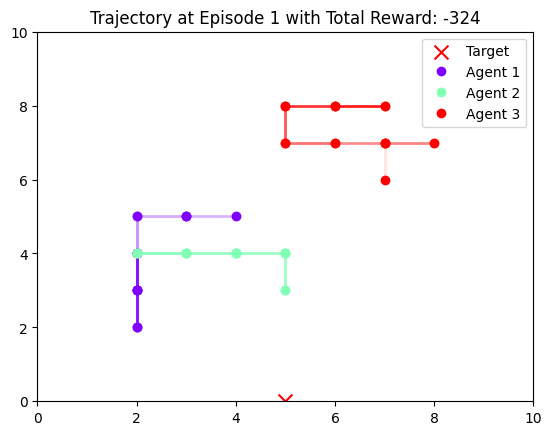

Episode 2: Total Reward: -366


<Figure size 640x480 with 0 Axes>

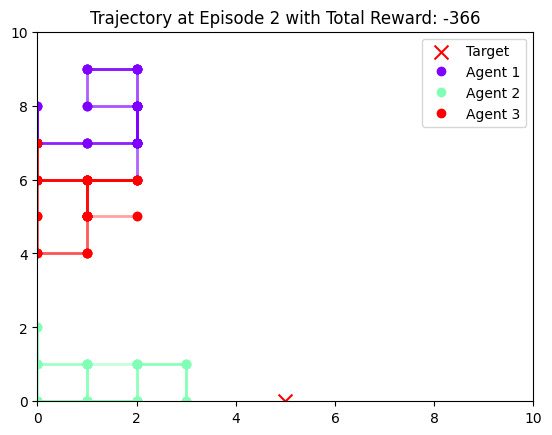

Episode 3: Total Reward: -513


<Figure size 640x480 with 0 Axes>

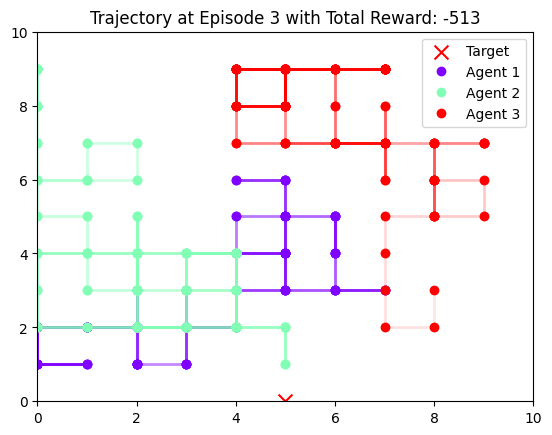

Episode 4: Total Reward: -300


<Figure size 640x480 with 0 Axes>

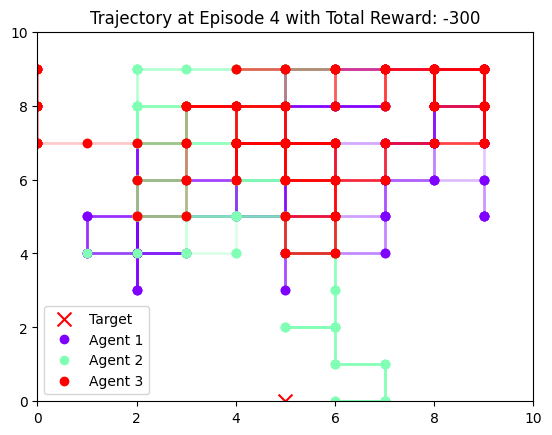

Episode 5: Total Reward: -300


<Figure size 640x480 with 0 Axes>

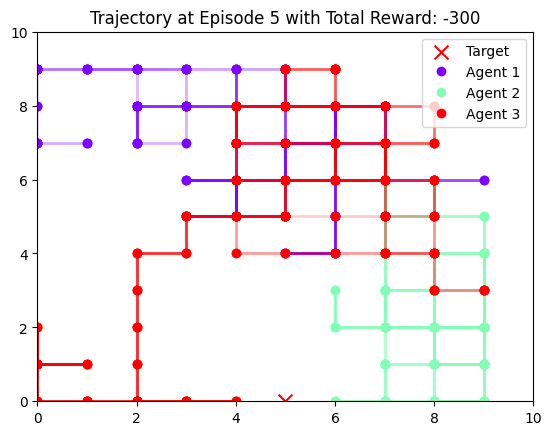

Testing setup 1 at Episode 1000
Episode 1: Total Reward: 696


<Figure size 640x480 with 0 Axes>

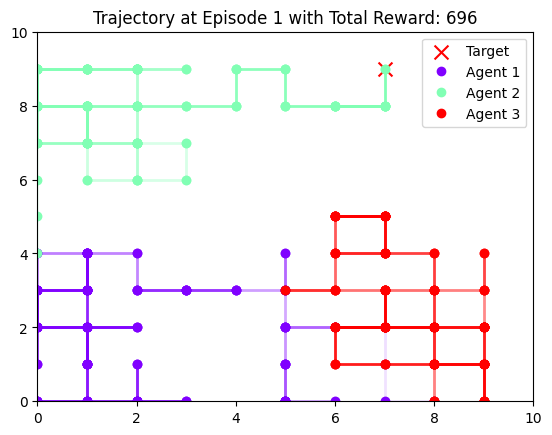

Episode 2: Total Reward: -312


<Figure size 640x480 with 0 Axes>

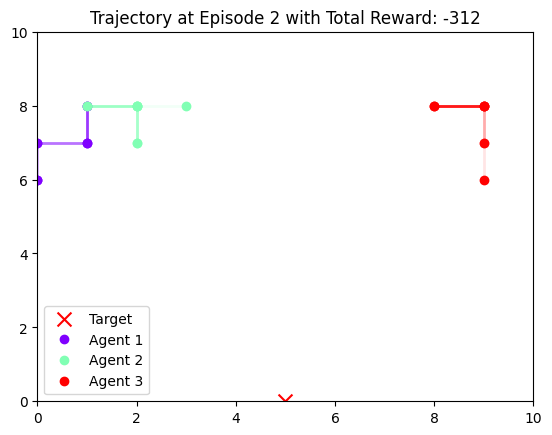

Episode 3: Total Reward: 0


<Figure size 640x480 with 0 Axes>

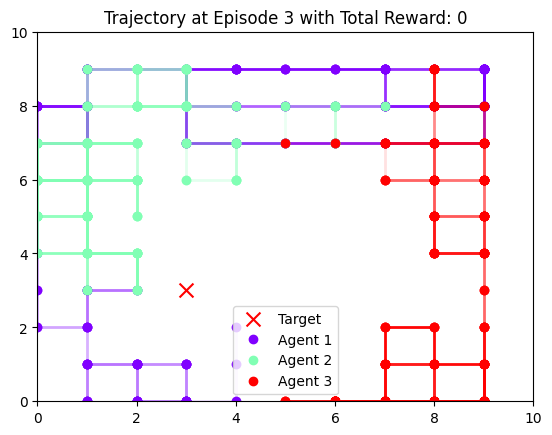

Episode 4: Total Reward: 0


<Figure size 640x480 with 0 Axes>

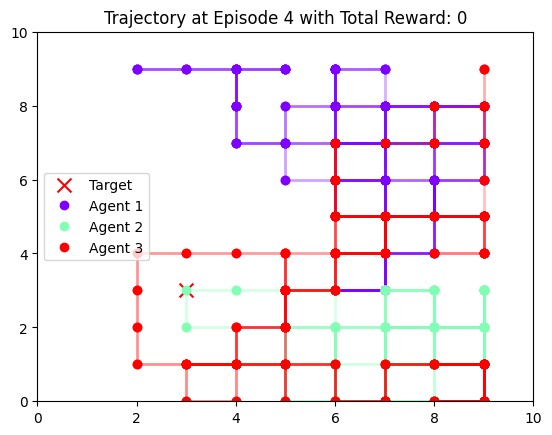

Episode 5: Total Reward: -309


<Figure size 640x480 with 0 Axes>

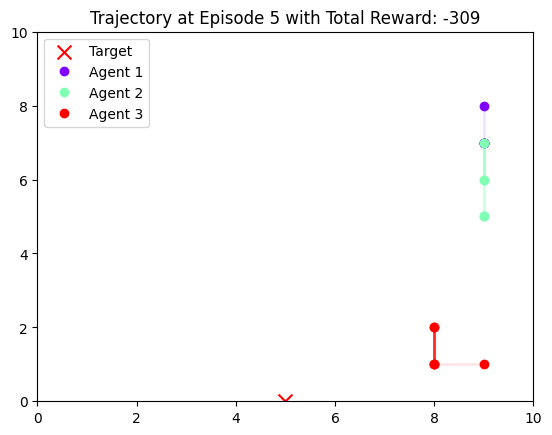

Testing setup 1 at Episode 10000
Episode 1: Total Reward: 300


<Figure size 640x480 with 0 Axes>

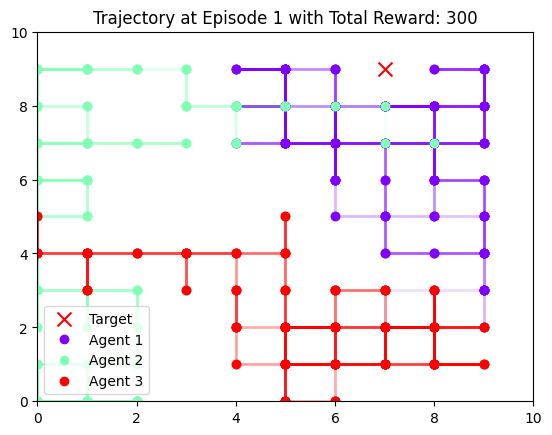

Episode 2: Total Reward: -300


<Figure size 640x480 with 0 Axes>

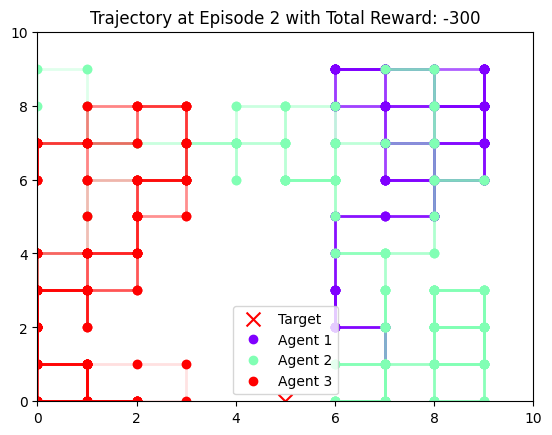

Episode 3: Total Reward: -363


<Figure size 640x480 with 0 Axes>

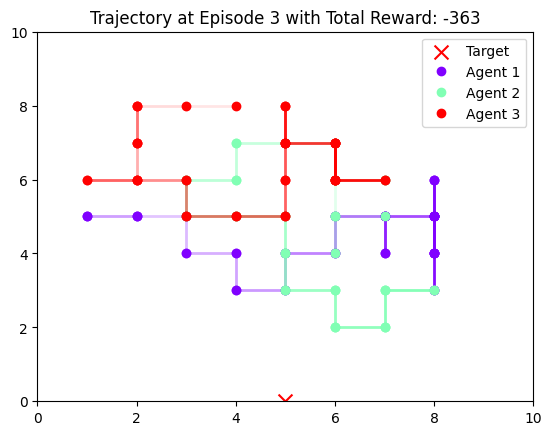

Episode 4: Total Reward: -453


<Figure size 640x480 with 0 Axes>

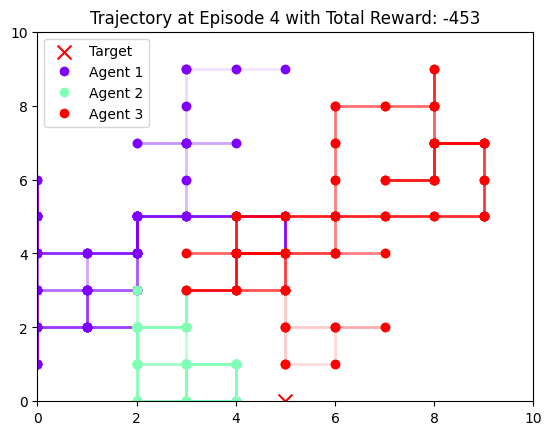

Episode 5: Total Reward: -342


<Figure size 640x480 with 0 Axes>

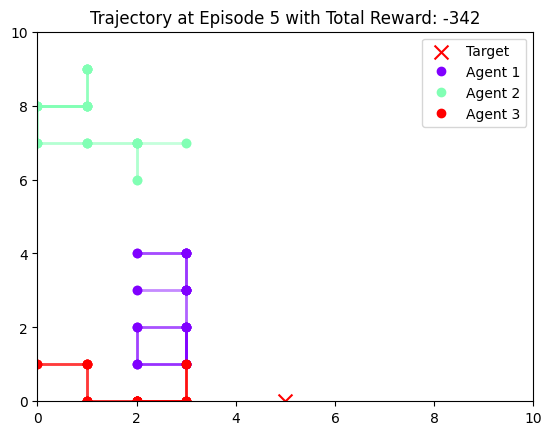

Testing setup 1 at Episode 50000
Episode 1: Total Reward: -450


<Figure size 640x480 with 0 Axes>

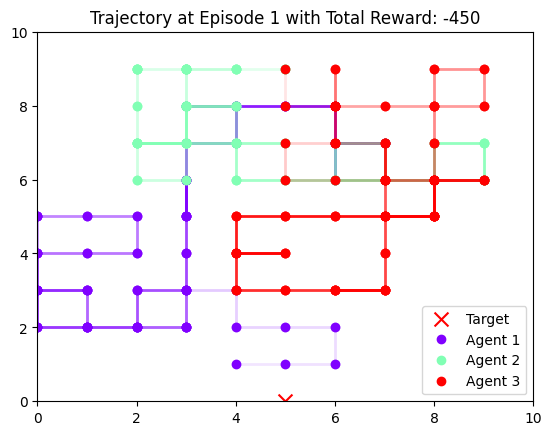

Episode 2: Total Reward: 300


<Figure size 640x480 with 0 Axes>

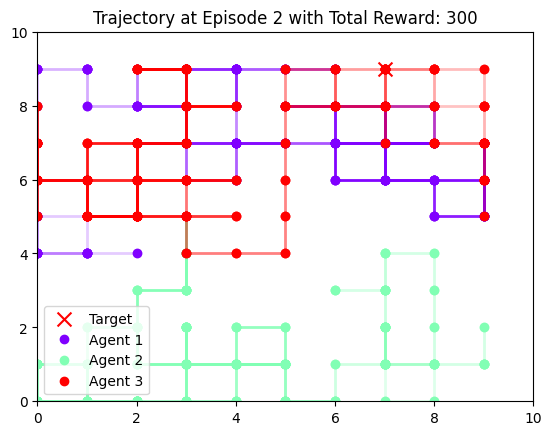

Episode 3: Total Reward: -348


<Figure size 640x480 with 0 Axes>

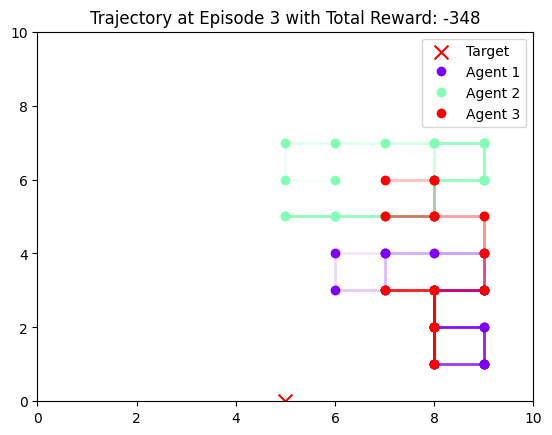

Episode 4: Total Reward: -300


<Figure size 640x480 with 0 Axes>

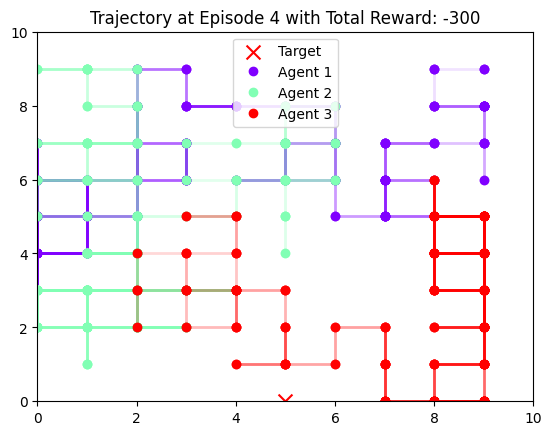

Episode 5: Total Reward: 300


<Figure size 640x480 with 0 Axes>

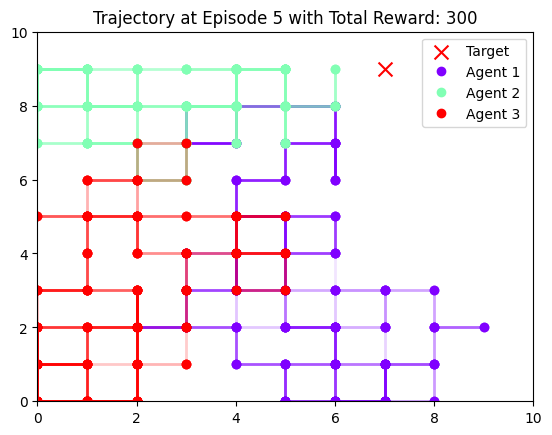

Testing setup 1 at Episode 100000
Episode 1: Total Reward: 264


<Figure size 640x480 with 0 Axes>

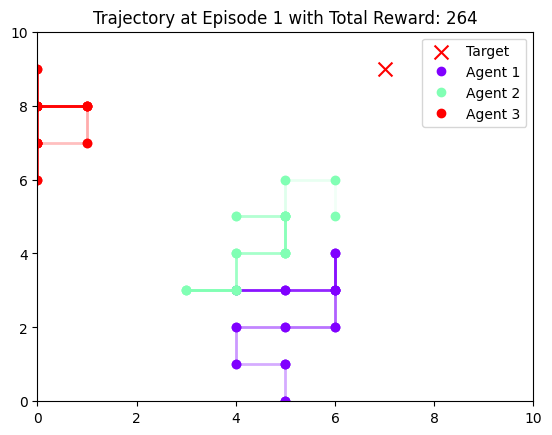

Episode 2: Total Reward: -465


<Figure size 640x480 with 0 Axes>

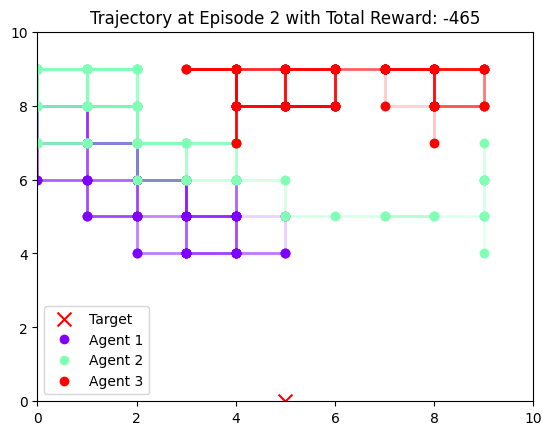

Episode 3: Total Reward: -363


<Figure size 640x480 with 0 Axes>

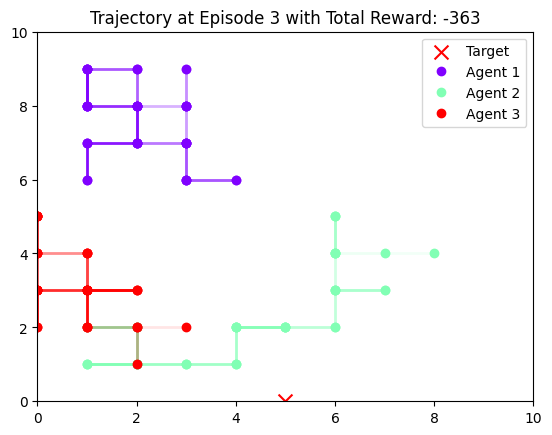

Episode 4: Total Reward: -363


<Figure size 640x480 with 0 Axes>

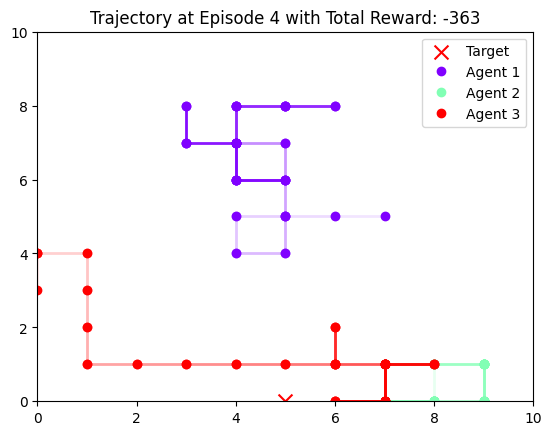

Episode 5: Total Reward: -333


<Figure size 640x480 with 0 Axes>

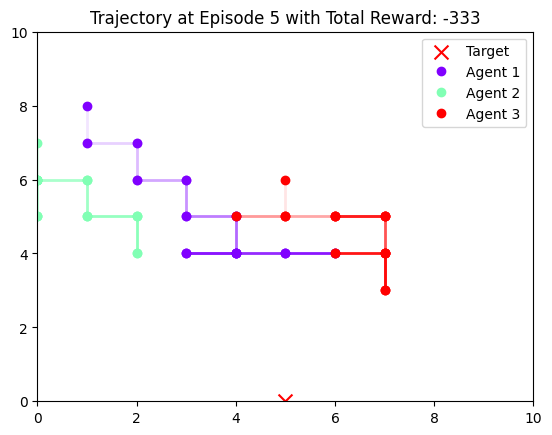

Testing setup 1 at Episode 500000
Episode 1: Total Reward: -27


<Figure size 640x480 with 0 Axes>

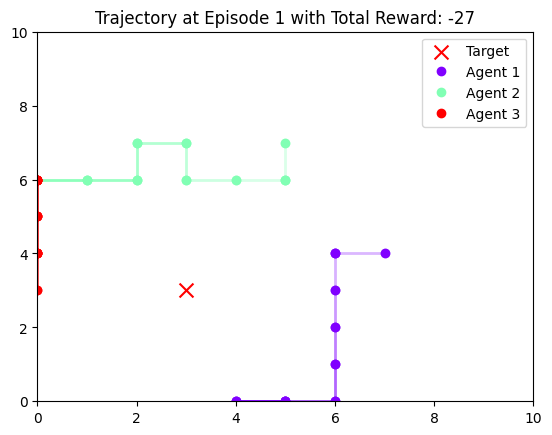

Episode 2: Total Reward: -450


<Figure size 640x480 with 0 Axes>

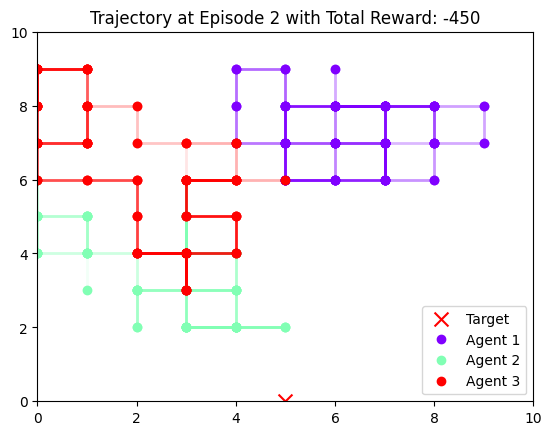

Episode 3: Total Reward: -324


<Figure size 640x480 with 0 Axes>

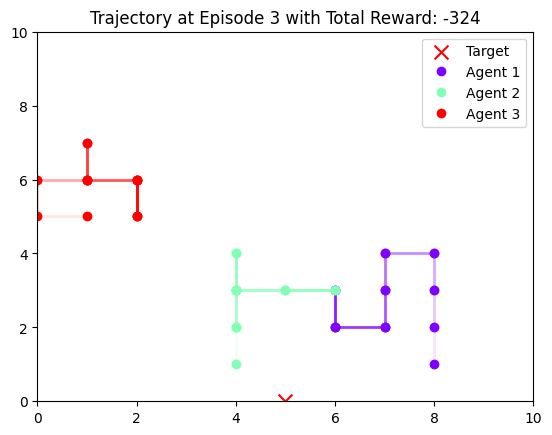

Episode 4: Total Reward: -498


<Figure size 640x480 with 0 Axes>

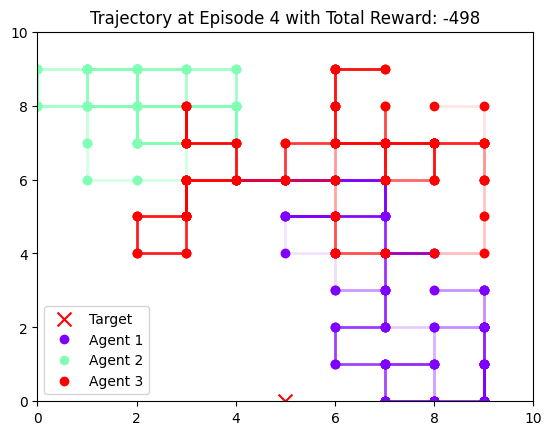

Episode 5: Total Reward: -342


<Figure size 640x480 with 0 Axes>

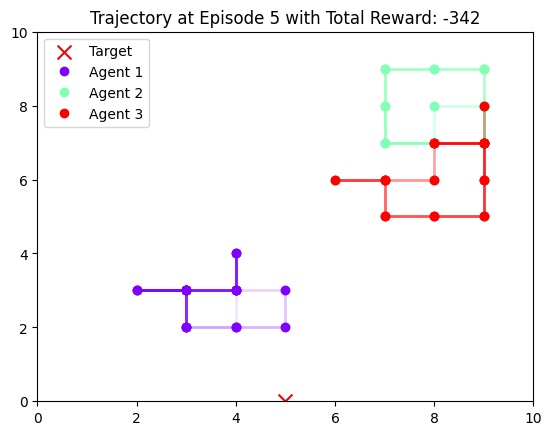

In [23]:
# Set random seed for reproducibility
np.random.seed(0)
random.seed(0)

setup = 1
testing_eps = [100, 1000, 10000, 50000, 100000, 500000]
mean_rewards = []
test_agent = StageAwareQLearning(action_size)
env = SequentialGoalsEnvironment(grid_size, target_positions)

for ep in testing_eps:
    print(f'Testing setup {setup} at Episode {ep}')
    test_agent.load(f'./policies/{setup}_ep_{ep}.pkl')
    mean_rewards.append(test_q_learning(episodes=5, max_steps=100, agent=test_agent, env=env, tr_episodes=ep))
    print('========================')

## Using Stage Information

In [13]:
# Set random seed for reproducibility
np.random.seed(0)
random.seed(0)

grid_size = 10
target_positions = [np.random.randint(0, grid_size, 2) for _ in range(3)]
target_position = target_positions[0]

env = Environment(grid_size, target_position)

seq_env = SequentialGoalsEnvironment(grid_size, target_positions)

action_size = 4  # Up, Down, Left, Right
agent = QLearning(action_size)

seq_agent = StageAwareQLearning(action_size)

In [21]:
env._get_state()

((3, 5), (2, 4), (7, 6), 0)

In [19]:
tuple(target_position) in env._get_state()

False

In [10]:
None is None

True